In [34]:
!pip install scikeras
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.pipeline import Pipeline # for setting up a pre-processing / tuning pipeline.
from sklearn.preprocessing import RobustScaler # Here, we are going to normalize inputs.

from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

#*Grid Search CV With Keras Model*

In [172]:
# Make sure you set your custom parameters for training as arguments in your model creation function.
def create_model(optimizer="sgd",activation="relu",units=50,numLayers=2, batch_size=10):
    
    # You'll want to invoke the sequential API this way and explicitly declare an input layer.
    model = keras.Sequential()
    model.add(layers.Input(train_data.shape[1]))
    model.add(layers.Dense(units, activation="relu"))

    if numLayers == 2:
        model.add(layers.Dense(units, activation="relu"))

    model.add(layers.Dense(1, activation=activation))

    model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=['mse'])
    return model

# You also need to specify the 'custom' parameters here that you want to add, for them to show up as a trainable parameter in GridSearchCV.
regf = KerasRegressor(model=create_model, optimizer="adam", activation="relu", units=64, numLayers=2, batch_size=10, verbose=0)

# Note you can also do a grid search over an sklearn pipeline, so you can search over diferent types of data pre-processing approaches too!
ml_pipeline = Pipeline([("Normalize", RobustScaler()), ("Model", regf)])

# Here are the configurable parameters we can now search over for either object. 
print(regf.get_params().keys())
print(ml_pipeline.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'activation', 'units', 'numLayers'])
dict_keys(['memory', 'steps', 'verbose', 'Normalize', 'Model', 'Normalize__copy', 'Normalize__quantile_range', 'Normalize__unit_variance', 'Normalize__with_centering', 'Normalize__with_scaling', 'Model__model', 'Model__build_fn', 'Model__warm_start', 'Model__random_state', 'Model__optimizer', 'Model__loss', 'Model__metrics', 'Model__batch_size', 'Model__validation_batch_size', 'Model__verbose', 'Model__callbacks', 'Model__validation_split', 'Model__shuffle', 'Model__run_eagerly', 'Model__epochs', 'Model__activation', 'Model__units', 'Model__numLayers'])


In [173]:
from sklearn.model_selection import GridSearchCV

# Because we are creating the models but are not compiling them yet (we will let the grid fit compile the models on the fly),
# this will produce a bunch of warnings. I'm just suppressing the warnings. 
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

params = {
    "numLayers": [1,2],
    "units": [100,75,50,25],
    "activation": ['relu','linear'],
    "batch_size": [25,50],
    #"epochs":[10,20],
    #"optimizer": ["adam", "adadelta"]
}

grid = GridSearchCV(regf, params, scoring='neg_mean_squared_error',verbose=0)#,cv=10)

grid.fit(train_data, train_targets)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 439, in mean_squared_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dty

GridSearchCV(estimator=KerasRegressor(activation='relu', batch_size=10, model=<function create_model at 0x7f43b037fdd0>, numLayers=2, optimizer='adam', units=64, verbose=0),
             param_grid={'activation': ['relu', 'linear'],
                         'batch_size': [25, 50], 'numLayers': [1, 2],
                         'units': [100, 75, 50, 25]},
             scoring='neg_mean_squared_error')

In [170]:
print(f"Best Score  : {grid.best_score_}")
print(f"Best Params : {grid.best_params_}")

Best Score  : -586.3089311728395
Best Params : {'activation': 'relu', 'batch_size': 8, 'epochs': 10, 'numLayers': 1, 'optimizer': 'adam', 'units': 128}


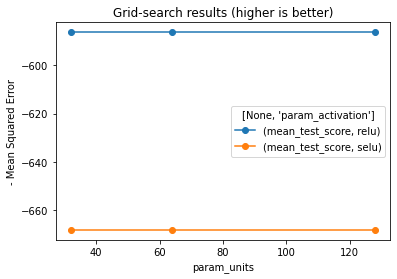

In [171]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(index='numLayers', columns='activation'):
    index = 'param_' + index
    columns = 'param_' + columns

    # prepare the results into a pandas.DataFrame
    df = pd.DataFrame(grid.cv_results_)

    # Remove the other by selecting their best values (from gscv.best_params_)
    other = [c for c in df.columns if c[:6] == 'param_']
    other.remove(index)
    other.remove(columns)

    # Set all other parameters to their "top" values.
    for col in other:
        df = df[df[col] == grid.best_params_[col[6:]]]

    # Create pivot tables for easy plotting
    table_mean = df.pivot_table(index=index, columns=columns,
                                values=['mean_test_score'])
    
    # plot the pivot tables
    plt.figure()
    ax = plt.gca()
    for col_mean in table_mean.columns:
        table_mean[col_mean].plot(marker='o',label=col_mean)
    plt.title('Grid-search results (higher is better)')
    plt.ylabel('- Mean Squared Error')
    plt.legend(title=table_mean.columns.names)
    plt.show()


plot_results(index='units', columns='activation')